In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use("seaborn-white")
mpl.rcParams['figure.figsize']=(8,6)

import scipy.constants as cst
from lammpsrun import LAMMPS, Prism
import os, sys, shutil

from ase import Atoms
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io.trajectory import Trajectory
from ase.io import write, read
from ase.build import molecule
from ase.spacegroup import crystal
from ase.data import atomic_numbers, atomic_names, atomic_masses, covalent_radii

import pandas as pd
import seaborn as sns

# homepath = "G:\\home\\LAMMPS_Simulation\\"
hpc_path = "G:\\home\\LAMMPS_Simulation\\HPC_Jupyter\\"
ephemeral_path = "G:\\ephemeral\\"
# ephemeral_path = "/local/yiming/Desktop/yx6015/ephemeral/"
# print(homepath + '\n' + hpc_path)

In [2]:
# 30MVcm seems to have issues
Fe_aq_names =  ['Fe_aq_co2_efields_40MVcm']
Fe_aq_out = ['73481.pbs']

In [3]:
traj_lists = []
bonds_list = []
connectivity_list = []
for name, outdir in zip(Fe_aq_names, Fe_aq_out):
    bonds_list.append(os.path.join(ephemeral_path, outdir, "bonds_atoms.hdf5"))
    connectivity_list.append(os.path.join(ephemeral_path, outdir, "bonds_connectivity.hdf5"))
    traj_lists.append(Trajectory(os.path.join(ephemeral_path, outdir, name+".traj"), 'r'))

In [4]:
log_dfs = []
log_reader = LAMMPS()
for outdir in Fe_aq_out:
    log_path = os.path.join(ephemeral_path, outdir, "log.lammps")
    log_reader.read_lammps_log(log_path)
    traj_df = pd.DataFrame(log_reader.thermo_content)
    if len(traj_df) > 0:
        traj_df.set_index('step', inplace=True)
    log_dfs.append(traj_df)

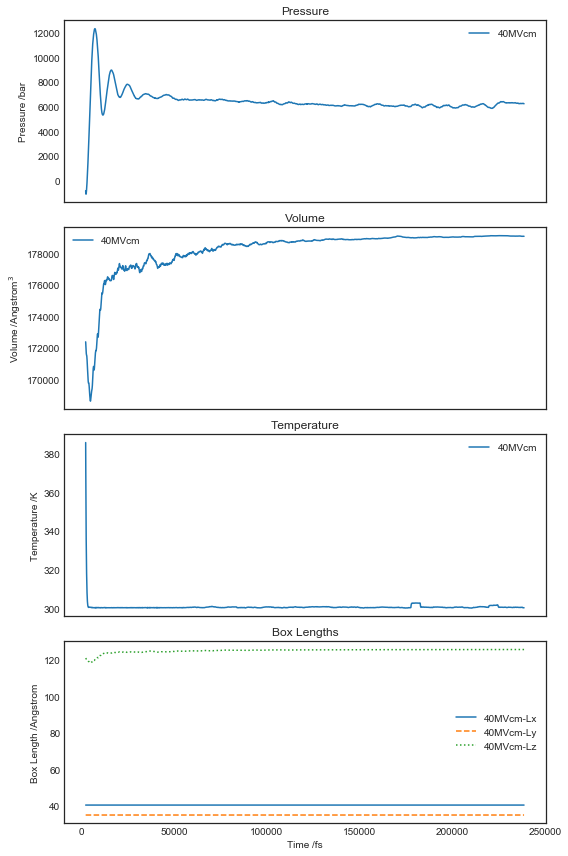

In [6]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(8, 12))
ax1.set_title('Pressure')
ax2.set_title('Volume')
ax3.set_title('Temperature')
ax4.set_title('Box Lengths')

for df, name in zip(log_dfs, [x.split('_')[-1] for x in Fe_aq_names]):
    if len(df) == 0: continue
    ax1.plot(df.index/10, df.press.rolling(5000, center=True).mean(), label = name)
    ax2.plot(df.index/10, df.vol.rolling(5000, center=True).mean(), label = name)
    ax3.plot(df.index/10, df.temp.rolling(5000, center=True).mean(), label = name)

    ax4.plot(df.index/10, df.lx.rolling(5000, center=True).mean(), label = name+'-Lx', ls = '-')
    ax4.plot(df.index/10, df.ly.rolling(5000, center=True).mean(), label = name+'-Ly', ls = '--')
    ax4.plot(df.index/10, df.lz.rolling(5000, center=True).mean(), label = name+'-Lz', ls = ':')

ax1.set_ylabel("Pressure /bar")
ax2.set_ylabel("Volume /Angstrom$^3$")
ax3.set_ylabel("Temperature /K")
ax4.set_ylabel("Box Length /Angstrom")
ax4.set_xlabel("Time /fs")

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend(ncol=1)
f.tight_layout()
plt.show()

## Collate Prior Data

In [5]:
sim_list = {'trajectory': traj_lists,
            'log_df': log_dfs,
            'names': [x.split('_')[-1] for x in Fe_aq_names],
            'bonds_list': bonds_list,
            'connectivity_list': connectivity_list,
            'symbols': np.array(traj_lists[0][0].symbols)}

## Location of Atoms

In [85]:
steps_to_read = np.linspace(0, len(sim_list['trajectory'][0])-1, 10000, dtype=int)

In [83]:
# positions_z = []
# for traj in sim_list['trajectory']:
#     positions_z.append(np.array([traj[t].get_positions().astype(np.float32)[:, 2] for t in steps_to_read]))
# # Savinng binary somewhere
# np.save(file='Fe_aq_co2_long_pos_z', arr=positions_z)
# # Loading binary
sim_list['positions_z']=np.load('Fe_aq_co2_long_pos_z.npy')

### Visualization

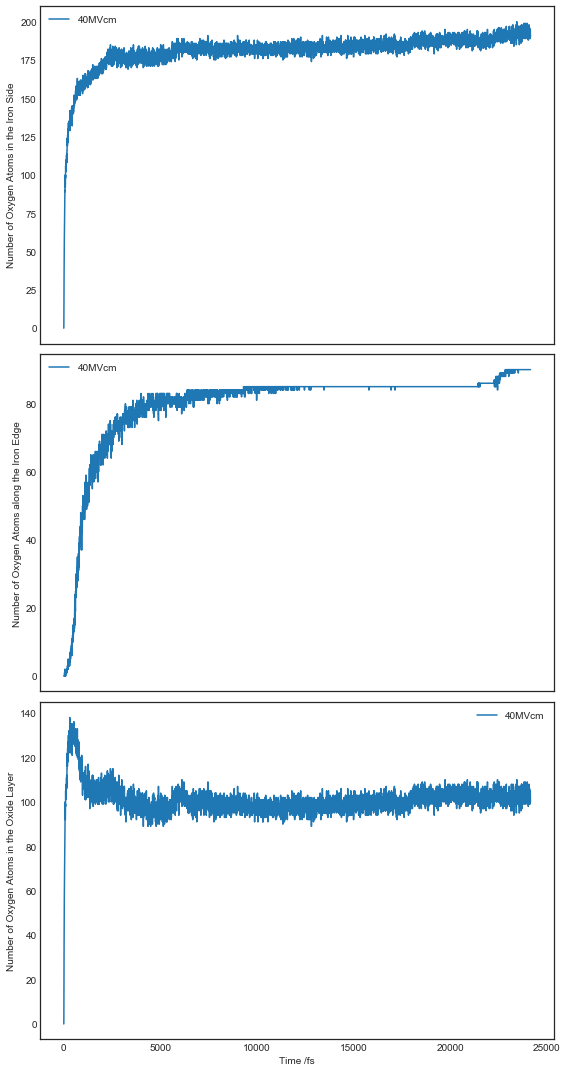

In [11]:
upper_cut_off = 97
lower_cut_off = 7

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 15), sharex=True)
for pos_z, name in zip(sim_list['positions_z'], sim_list['names']):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    O_pos_z = pos_z.T[sim_list['symbols']=='O'].T
    
    Fe_perc= np.percentile(Fe_pos_z, [lower_cut_off, upper_cut_off], axis = 1)
    
    O_below_upper = np.array([np.count_nonzero(i < j, axis = 0) for i, j in zip(O_pos_z, Fe_perc[1])])
    O_below_lower = np.array([np.count_nonzero(i < j) for i, j in zip(O_pos_z, Fe_perc[0])])
    O_middle = O_below_upper - O_below_lower
    
    ax1.plot(steps_to_read, O_below_upper, label = name)
    ax2.plot(steps_to_read, O_below_lower, label = name)
    ax3.plot(steps_to_read, O_middle, label = name)

ax1.set_ylabel("Number of Oxygen Atoms in the Iron Side")
ax2.set_ylabel("Number of Oxygen Atoms along the Iron Edge")
ax3.set_ylabel("Number of Oxygen Atoms in the Oxide Layer")

ax3.set_xlabel("Time /fs")

for ax in [ax1, ax2, ax3]:
    ax.legend()

f.tight_layout()
# f.savefig("fe_aq_co2_oxygen_distribution.png", dpi=400)
plt.show()

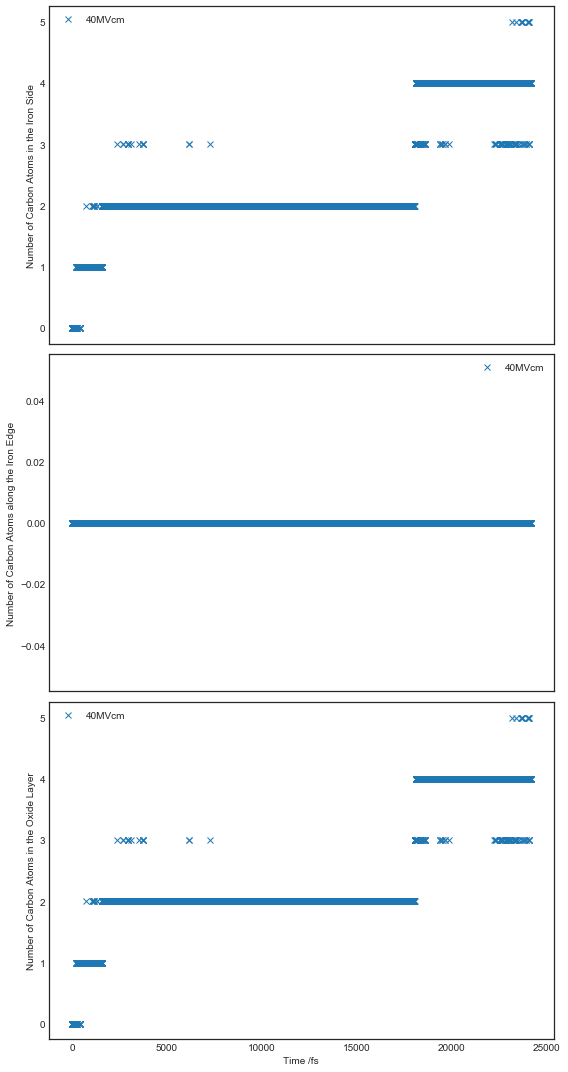

In [12]:
upper_cut_off = 97
lower_cut_off = 7

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 15), sharex=True)
for pos_z, name in zip(sim_list['positions_z'], sim_list['names']):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    C_pos_z = pos_z.T[sim_list['symbols']=='C'].T
    
    Fe_perc= np.percentile(Fe_pos_z, [lower_cut_off, upper_cut_off], axis = 1)
    
    C_below_upper = np.array([np.count_nonzero(i < j, axis = 0) for i, j in zip(C_pos_z, Fe_perc[1])])
    C_below_lower = np.array([np.count_nonzero(i < j) for i, j in zip(C_pos_z, Fe_perc[0])])
    C_middle = C_below_upper - C_below_lower
    
    ax1.plot(steps_to_read, C_below_upper, ' x', label = name)
    ax2.plot(steps_to_read, C_below_lower, ' x', label = name)
    ax3.plot(steps_to_read, C_middle, ' x', label = name)

ax1.set_ylabel("Number of Carbon Atoms in the Iron Side")
ax2.set_ylabel("Number of Carbon Atoms along the Iron Edge")
ax3.set_ylabel("Number of Carbon Atoms in the Oxide Layer")

ax3.set_xlabel("Time /fs")

for ax in [ax1, ax2, ax3]:
    ax.legend()

f.tight_layout()
# f.savefig("fe_aq_co2_carbon_distribution.png", dpi=400)
plt.show()

## Histogram of Distribution

### For Iron Atoms

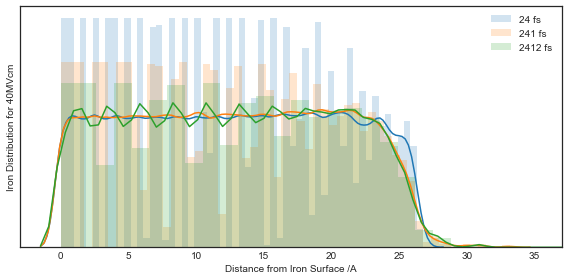

In [19]:
f, ax_arr = plt.subplots(len(sim_list['positions_z']), 1, figsize=(8, 4), sharex=True)
ax_arr = [ax_arr]
for pos_z, name, ax1 in zip(sim_list['positions_z'], sim_list['names'], ax_arr):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    Fe_lower = np.min(Fe_pos_z, axis = 1)
    Fe_delta = np.array([i-j for i, j in zip(Fe_pos_z, Fe_lower)])
    
    sns.distplot(Fe_delta[10], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[10]))
    sns.distplot(Fe_delta[1000], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[100]))
    sns.distplot(Fe_delta[10000-1], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[1000-1]))
    ax1.set_xlim(-3, 37)
    ax1.set_ylabel("Iron Distribution for " + name)
    ax1.set_yticks([], [])
    ax1.legend()
    
ax_arr[-1].set_xlabel('Distance from Iron Surface /A')
    
f.tight_layout()
# f.savefig("fe_aq_co2_iron_histogram.png", dpi=400)
plt.show()

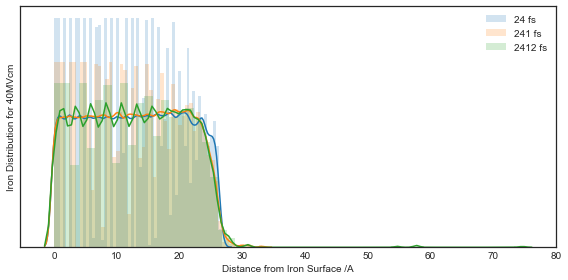

In [34]:
f, ax_arr = plt.subplots(len(sim_list['positions_z']), 1, figsize=(8, 4), sharex=True)
ax_arr = [ax_arr]
for pos_z, name, ax1 in zip(sim_list['positions_z'], sim_list['names'], ax_arr):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    Fe_lower = np.min(Fe_pos_z, axis = 1)
    Fe_delta = np.array([i-j for i, j in zip(Fe_pos_z, Fe_lower)])
    
    sns.distplot(Fe_delta[10], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[10]))
    sns.distplot(Fe_delta[1000], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[100]))
    sns.distplot(Fe_delta[10000-1], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[1000-1]))
#     ax1.set_xlim(30)
    ax1.set_ylabel("Iron Distribution for " + name)
    ax1.set_yticks([], [])
    ax1.legend()
    
ax_arr[-1].set_xlabel('Distance from Iron Surface /A')
    
f.tight_layout()
# f.savefig("fe_aq_co2_iron_histogram.png", dpi=400)
plt.show()

### For Oxygen Atoms

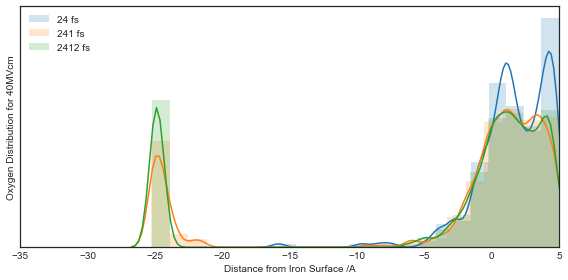

In [22]:
f, ax_arr = plt.subplots(len(sim_list['positions_z']), 1, figsize=(8, 4), sharex=True)
ax_arr = [ax_arr]
for pos_z, name, ax1 in zip(sim_list['positions_z'], sim_list['names'], ax_arr):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    O_pos_z = pos_z.T[sim_list['symbols']=='O'].T
    
    Fe_perc_upper = np.percentile(Fe_pos_z, 97, axis = 1)
    
    O_delta = np.array([i[i < j+5]-j for i, j in zip(O_pos_z, Fe_perc_upper)])
    
    sns.distplot(O_delta[10], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[10]))
    sns.distplot(O_delta[1000], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[100]))
    sns.distplot(O_delta[10000-1], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[1000-1]))
    ax1.set_xlim(-35, 5)
    ax1.set_ylabel("Oxygen Distribution for " + name)
    ax1.set_yticks([], [])
    ax1.legend()
    
ax_arr[-1].set_xlabel('Distance from Iron Surface /A')

f.tight_layout()
f.savefig("fe_aq_co2_oxygen_histogram.png", dpi=400)
plt.show()

### For Carbon Atoms

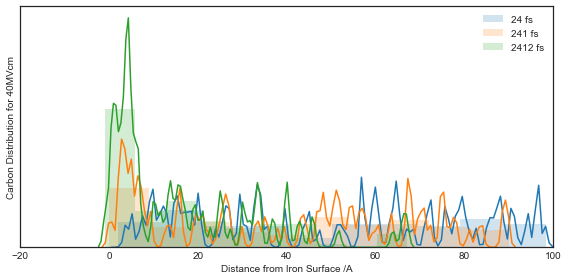

In [23]:
f, ax_arr = plt.subplots(len(sim_list['positions_z']), 1, figsize=(8, 4), sharex=True)
ax_arr = [ax_arr]
for pos_z, name, ax1 in zip(sim_list['positions_z'], sim_list['names'], ax_arr):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    C_pos_z = pos_z.T[sim_list['symbols']=='C'].T
    
    Fe_perc_upper = np.percentile(Fe_pos_z, 97, axis = 1)
    
    C_delta = np.array([i-j for i, j in zip(C_pos_z, Fe_perc_upper)])
    
    sns.distplot(C_delta[10], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[10]))
    sns.distplot(C_delta[100], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[100]))
    sns.distplot(C_delta[1000-1], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[1000-1]))
    ax1.set_xlim(-20, 100)
    ax1.set_ylabel("Carbon Distribution for " + name)
    ax1.set_yticks([], [])
    ax1.legend()
    
ax_arr[-1].set_xlabel('Distance from Iron Surface /A')

f.tight_layout()
f.savefig("fe_aq_co2_carbon_histogram_all.png", dpi=400)
plt.show()

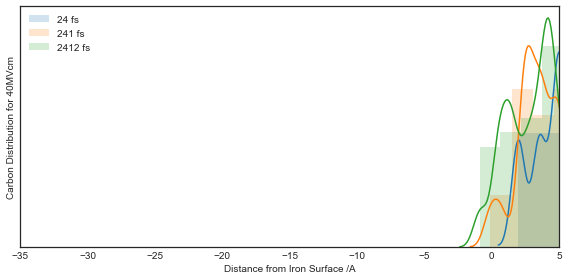

In [24]:
f, ax_arr = plt.subplots(len(sim_list['positions_z']), 1, figsize=(8, 4), sharex=True)
ax_arr = [ax_arr]
for pos_z, name, ax1 in zip(sim_list['positions_z'], sim_list['names'], ax_arr):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    C_pos_z = pos_z.T[sim_list['symbols']=='C'].T
    
    Fe_perc_upper = np.percentile(Fe_pos_z, 97, axis = 1)
    
    C_delta = np.array([i[i < j+10]-j for i, j in zip(C_pos_z, Fe_perc_upper)])
    
    sns.distplot(C_delta[10], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[10]))
    sns.distplot(C_delta[100], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[100]))
    sns.distplot(C_delta[1000-1], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[1000-1]))
    ax1.set_xlim(-35, 5)
    ax1.set_ylabel("Carbon Distribution for " + name)
    ax1.set_yticks([], [])
    ax1.legend()
    
ax_arr[-1].set_xlabel('Distance from Iron Surface /A')

f.tight_layout()
f.savefig("fe_aq_co2_carbon_histogram.png", dpi=400)
plt.show()

## For Hydrogen Atoms

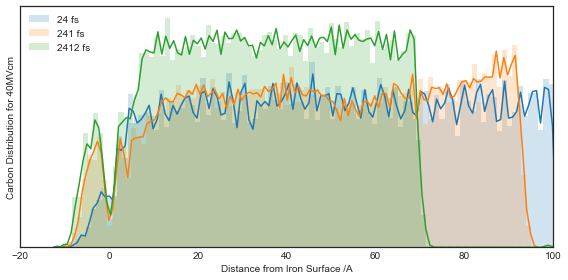

In [86]:
f, ax_arr = plt.subplots(len(sim_list['positions_z']), 1, figsize=(8, 4), sharex=True)
ax_arr = [ax_arr]
for pos_z, name, ax1 in zip(sim_list['positions_z'], sim_list['names'], ax_arr):
    Fe_pos_z = pos_z.T[sim_list['symbols']=='Fe'].T
    H_pos_z = pos_z.T[sim_list['symbols']=='H'].T
    
    Fe_perc_upper = np.percentile(Fe_pos_z, 97, axis = 1)
    
    H_delta = np.array([i-j for i, j in zip(H_pos_z, Fe_perc_upper)])
    
    sns.distplot(H_delta[10], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[10]))
    sns.distplot(H_delta[100], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[100]))
    sns.distplot(H_delta[1000-1], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax=ax1, label = '{} fs'.format(steps_to_read[1000-1]))
    ax1.set_xlim(-20, 100)
    ax1.set_ylabel("Carbon Distribution for " + name)
    ax1.set_yticks([], [])
    ax1.legend()
    
ax_arr[-1].set_xlabel('Distance from Iron Surface /A')

f.tight_layout()
f.savefig("fe_aq_co2_carbon_histogram_all.png", dpi=400)
plt.show()

## Charge of Various Species

In [38]:
from ase.visualize.plot import plot_atoms
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdBu,
                           norm=mpl.colors.Normalize(vmin=-1., vmax=1))
sm.set_array([])

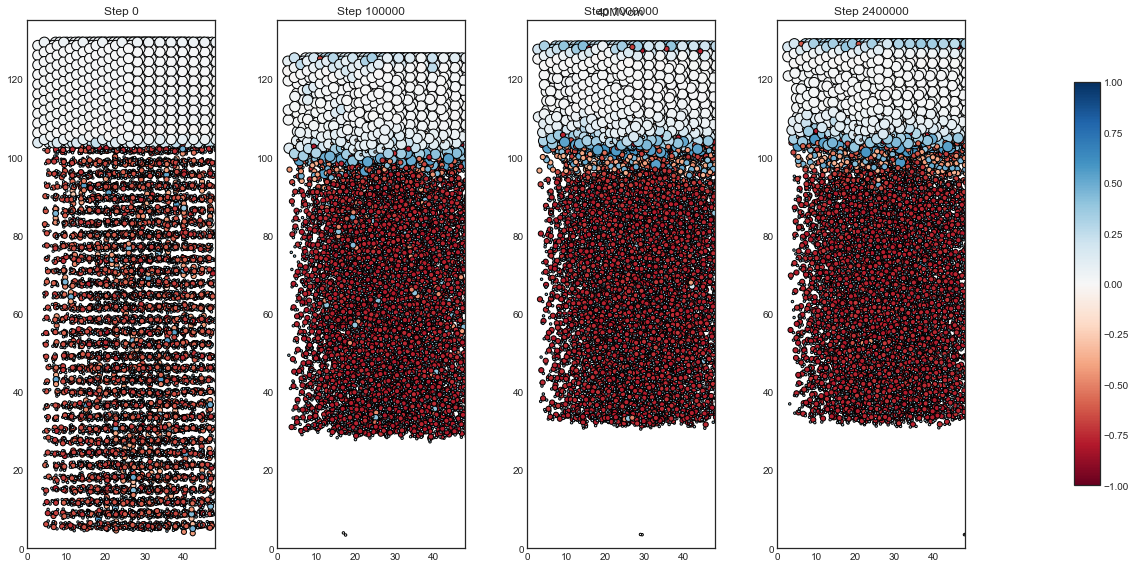

In [39]:
for traj, name, bl in zip(sim_list['trajectory'], sim_list['names'], sim_list['bonds_list']):
    f, ax_arr = plt.subplots(1, 4, figsize=(18, 8))
    
    for ax, step in zip(ax_arr, [0, 100000, 1000000, 2400000]):
        atom_df = pd.read_hdf(bl, key = 'step{}'.format(step//100))
        atom_color = sm.to_rgba(atom_df.charge)
        plot_atoms(traj[step//100], colors=atom_color, rotation=('90x, 45y, 0z'), ax=ax)
        ax.set_xlim(0, 48)
        ax.set_ylim(0, 135)
        ax.set_title('Step {}'.format(step))
        
    f.suptitle(name)
    f.tight_layout()
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.02, 0.7])
    f.colorbar(sm, cax=cbar_ax)
    
plt.show()

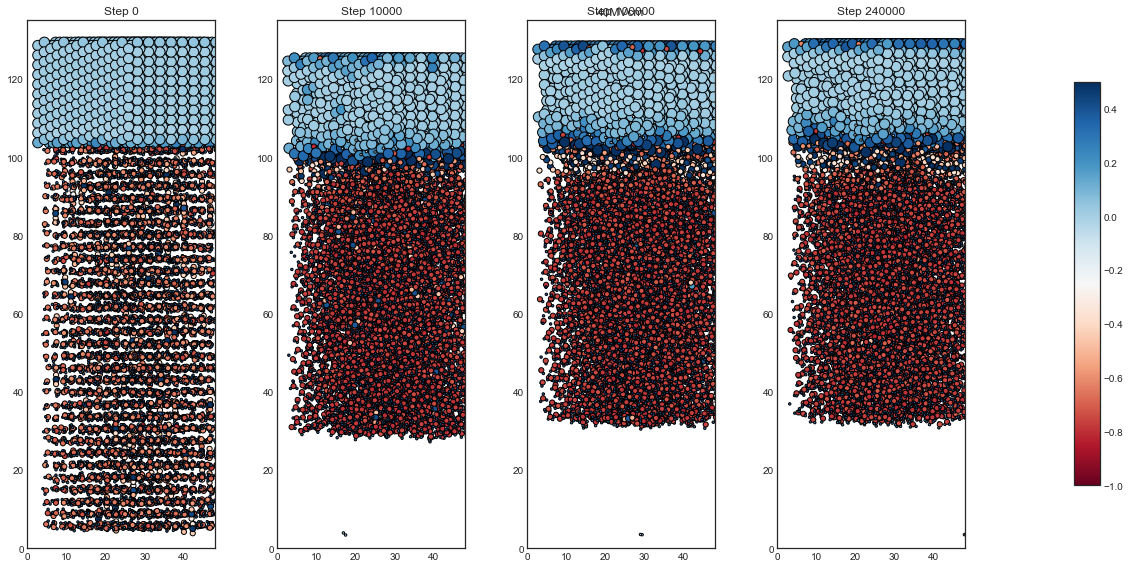

In [27]:
for traj, name, bl in zip(sim_list['trajectory'], sim_list['names'], sim_list['bonds_list']):
    f, ax_arr = plt.subplots(1, 4, figsize=(18, 8))
    
    for ax, step in zip(ax_arr, [0, 100000, 1000000, 2400000]):
        atom_df = pd.read_hdf(bl, key = 'step{}'.format(step//100))
        atom_color = sm.to_rgba(atom_df.charge)
        plot_atoms(traj[step//100], colors=atom_color, rotation=('90x, 45y, 0z'), ax=ax)
        ax.set_xlim(0, 48)
        ax.set_ylim(0, 135)
        ax.set_title('Step {}'.format(step))
        
    f.suptitle(name)
    f.tight_layout()
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.02, 0.7])
    f.colorbar(sm, cax=cbar_ax)
    
plt.show()

## Carbon Coordination

In [19]:
steps_list = np.linspace(0, 2400000, 5, dtype=int)
C_index = np.argwhere(sim_list['symbols']=='C').ravel()+1

In [79]:
# Large coordinated carbon
for cl, name, traj in zip(sim_list['connectivity_list'][-1:], sim_list['names'][-1:], sim_list['trajectory'][-1:]):
    print('*'*50)
    print(name)
    print('*'*50)
    
    for step, ax in zip(steps_list, ax_arr):
        print('*'*20, 'Step', step, '*'*20)
        
        step_df = pd.read_hdf(cl, key = 'step{}'.format(step//10))
        primary_atoms = [[x] + step_df[step_df.atom_a==x].atom_b.to_list() for x in C_index]
        primary_atoms = [x for x in primary_atoms if len(x) > 3]
        
        secondary_atoms = [[[x] + step_df[step_df.atom_a==x].atom_b.to_list() for x in y] for y in primary_atoms]
        atoms_to_plot = [list(set([x for y in z for x in y])) for z in secondary_atoms]
        
        atoms_to_plot = [x for x in atoms_to_plot if np.any(traj[step//10][np.array(x)-1].get_positions()[:, 2]<35)]
        
        for atoms in atoms_to_plot:
#             f, ax = plt.subplots(figsize = (5, 5))
#             plot_atoms(traj[step][np.array(atoms)-1], ax = ax, rotation=('90x,40y,0z'))
            view(traj[step//10][np.array(atoms)-1])
#             ax.set_title('Step {}'.format(step))
#             plt.show()
# #         print(len(connected_atoms))
#         coordination = np.array([len(x) for x in connected_atoms])
        

**************************************************
50MVcm
**************************************************
******************** Step 0 ********************
******************** Step 150000 ********************
******************** Step 300000 ********************
******************** Step 450000 ********************
******************** Step 600000 ********************


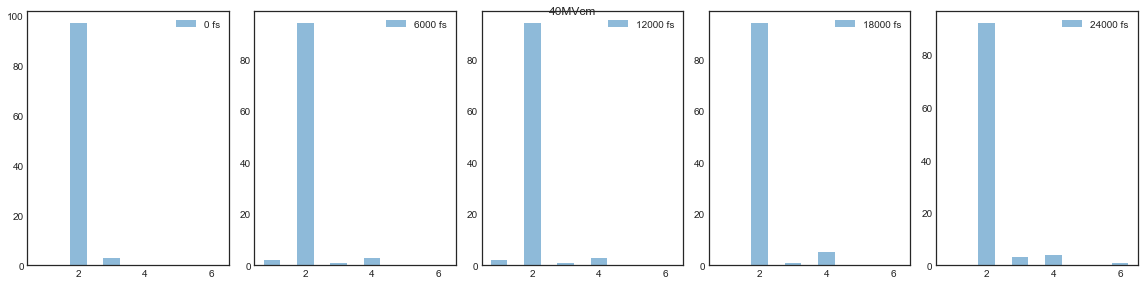

In [30]:
for cl, name in zip(sim_list['connectivity_list'], sim_list['names']):
    f, ax_arr = plt.subplots(1, 5, figsize=(16, 4))

    for step, ax in zip(steps_list, ax_arr):
        step_df = pd.read_hdf(cl, key = 'step{}'.format(step//100))
        coordination = np.array([len(step_df[step_df.atom_a==x]) for x in C_index])
        
        sns.distplot(coordination, kde=False,
                     bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5],
                     hist_kws={'alpha': 0.5, 'align': 'mid', 'rwidth': 0.5},
                     ax=ax, label = '{} fs'.format(step//100))
        ax.legend()
        
    f.tight_layout()
    f.suptitle(name)
plt.show()

## Radial Distribution Function

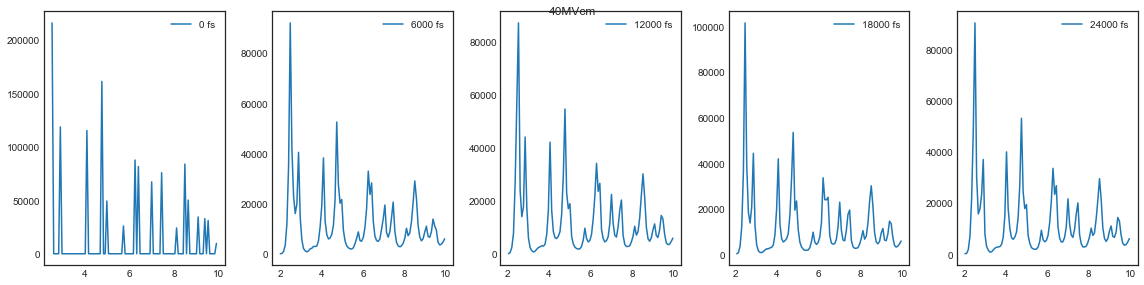

In [31]:
from ase.neighborlist import neighbor_list
for traj, name in zip(sim_list['trajectory'], sim_list['names']):
    f, ax_arr = plt.subplots(1, 5, figsize=(16, 4))
    
    for ax, step in zip(ax_arr, steps_list):
        fe_only = traj[step//100][sim_list['symbols'] == 'Fe']
        d = neighbor_list('d', fe_only, 10.00)
        h, bin_edges = np.histogram(d, bins=100)
        pdf = h/(4*np.pi/3*(bin_edges[1:]**3 - bin_edges[:-1]**3)) * fe_only.get_volume()/len(fe_only)
        x_axis = (bin_edges[1: ] + bin_edges[:-1])/2
        
        ax.plot(x_axis, pdf, label = '{} fs'.format(step//100))
        ax.legend()
    f.suptitle(name)
    f.tight_layout()
    
plt.show()

## Carbon Molecules

In [74]:
def plot_connected_molecule_from_df(atom_id, step_df):
    import networkx as nx
    from ase.data.colors import jmol_colors
    from ase.data import atomic_numbers
    G = nx.from_pandas_edgelist(
        step_df, source='atom_a', target='atom_b', edge_attr=['bond_order'])
    G_connected = nx.connected_components(G)
    for i in G_connected:
        if atom_id in i:
            if len(i) > 16:
                print("The atom {} connected to {} other atom is probably a bulk molecule. Not plotting.".format(atom_id, len(i)))
                break
            fig = plt.figure(figsize=(3, 3))

            sub_G = G.subgraph(i)
            edge_labels = nx.get_edge_attributes(sub_G, 'bond_order')
            node_labels = dict(
                zip(i, sim_list['symbols'][np.array(list(i))-1]))
            colors = [jmol_colors[atomic_numbers[v]] for k, v in node_labels.items()]

            pos = nx.spring_layout(sub_G)

            nx.draw(sub_G, pos, node_color=colors)
            nx.draw_networkx_labels(sub_G, pos,  node_labels)
    #         nx.draw_networkx_edge_labels(sub_G, pos, edge_labels)
            fig.set_facecolor("#c9c9c9")

## Carbon Molecule Counting

In [31]:
molecule_step_list = np.linspace(0, 24000, 1000, dtype=int)

In [43]:
import networkx as nx
from ase.data import atomic_numbers

for cl, name in zip(sim_list['connectivity_list'][-1:], sim_list['names'][-1:]):
    step_molecules = []
    print('*'*50)
    print(name)
    print('*'*50)
    
    for step in molecule_step_list:
        step_df = pd.read_hdf(cl, key = 'step{}'.format(step))
        coordination = np.array([len(step_df[step_df.atom_a==x]) for x in C_index])
        G = nx.from_pandas_edgelist(step_df, source='atom_a', target='atom_b', edge_attr=['bond_order'])
        molecule_collection = []
        
        for i in C_index[coordination>1]:
            G_subset = nx.node_connected_component(G, i)
            molecule =  sim_list['symbols'][np.array(list(G_subset))-1]
            elements, subscripts = np.unique(molecule, return_counts=True)
            molecule_collection.append(''.join(["{}{}".format(a, b) if b > 1 else "{}".format(a) for (a, b)in zip(elements, subscripts)]))
        molecule_collection_unique = np.unique(np.array(molecule_collection), return_counts=True)
        molecule_dict = dict(zip(molecule_collection_unique[0], molecule_collection_unique[1]))
        step_molecules.append(molecule_dict)

**************************************************
40MVcm
**************************************************
[{'C2Fe3200H212O110': 2, 'C2H2O5': 4, 'C2H4O6': 4, 'CH2O3': 34, 'CH3O4': 1, 'CH4O4': 7, 'CH6O5': 1, 'CO2': 46, 'CO3': 1}, {'CFe3200H294O151': 1, 'CH2O2': 1, 'CH3O3': 1, 'CH9O5': 1, 'CHO2': 5, 'CO2': 88}, {'CFe3200H367O188': 1, 'CH8O5': 1, 'CHO2': 5, 'CO2': 90}, {'CFe3200H415O212': 1, 'CH6O4': 1, 'CH7O5': 1, 'CHO2': 1, 'CO2': 93}, {'CFe3200H434O222': 1, 'CH5O4': 2, 'CO2': 94}, {'CFe3200H454O232': 1, 'CH4O4': 1, 'CH5O4': 1, 'CO2': 94}, {'CFe3200H468O239': 1, 'CH4O4': 1, 'CH5O4': 1, 'CO2': 94}, {'CFe3200H484O247': 1, 'CH4O4': 1, 'CH7O5': 1, 'CO2': 94}, {'CFe3200H488O249': 1, 'CH4O4': 1, 'CH7O5': 1, 'CO2': 94}, {'CFe3200H499O255': 1, 'CH4O4': 1, 'CH5O4': 1, 'CO2': 94}, {'CFe3200H509O260': 1, 'CH4O4': 1, 'CH5O4': 1, 'CO2': 94}, {'CFe3200H517O264': 1, 'CH4O4': 1, 'CH7O5': 1, 'CO2': 94}, {'CFe3200H519O265': 1, 'CH4O4': 1, 'CH5O4': 1, 'CO2': 94}, {'CFe3200H525O268': 1, 'CH6O5': 1, 'CH7O

In [87]:
step_molecules[-1]

{'C3Fe3196H717O376': 3, 'CH2O3': 1, 'CH4O4': 4, 'CO2': 92}

In [75]:
molecule_df = pd.DataFrame(step_molecules, index=molecule_step_list)
large_columns = [x for x in molecule_df.columns if 'Fe' in x]

# Need to correct for extra counting of molecules with multiple carbons
for a, b in molecule_df.iteritems():
    if a[1].isdigit():
        molecule_df[a] = b/int(a[1])

# Collate carbon attached to the bulk
molecule_df['bulk'] = molecule_df[large_columns].sum(axis=1)
molecule_df = molecule_df.drop(columns=large_columns)

## Bulk Molecule Tracking

In [88]:
molecule_step_list

array([    0,    24,    48,    72,    96,   120,   144,   168,   192,
         216,   240,   264,   288,   312,   336,   360,   384,   408,
         432,   456,   480,   504,   528,   552,   576,   600,   624,
         648,   672,   696,   720,   744,   768,   792,   816,   840,
         864,   888,   912,   936,   960,   984,  1009,  1033,  1057,
        1081,  1105,  1129,  1153,  1177,  1201,  1225,  1249,  1273,
        1297,  1321,  1345,  1369,  1393,  1417,  1441,  1465,  1489,
        1513,  1537,  1561,  1585,  1609,  1633,  1657,  1681,  1705,
        1729,  1753,  1777,  1801,  1825,  1849,  1873,  1897,  1921,
        1945,  1969,  1993,  2018,  2042,  2066,  2090,  2114,  2138,
        2162,  2186,  2210,  2234,  2258,  2282,  2306,  2330,  2354,
        2378,  2402,  2426,  2450,  2474,  2498,  2522,  2546,  2570,
        2594,  2618,  2642,  2666,  2690,  2714,  2738,  2762,  2786,
        2810,  2834,  2858,  2882,  2906,  2930,  2954,  2978,  3003,
        3027,  3051,

In [89]:
import networkx as nx
from ase.data import atomic_numbers

step_df = pd.read_hdf(cl, key = 'step{}'.format(molecule_step_list[-1]))
coordination = np.array([len(step_df[step_df.atom_a==x]) for x in C_index])
G = nx.from_pandas_edgelist(step_df, source='atom_a', target='atom_b', edge_attr=['bond_order'])
bulk_carbon_id = [x for x in C_index[coordination>1] if len(nx.node_connected_component(G, x)) > 10]

In [98]:
for cl, name in zip(sim_list['connectivity_list'][-1:], sim_list['names'][-1:]):
    carbon_molecules = []
    
    for step in molecule_step_list:
        step_df = pd.read_hdf(cl, key = 'step{}'.format(step))
        coordination = np.array([len(step_df[step_df.atom_a==x]) for x in C_index])
        G = nx.from_pandas_edgelist(step_df, source='atom_a', target='atom_b', edge_attr=['bond_order'])
        molecule_collection = []
        
        for i in bulk_carbon_id:
            G_subset = nx.node_connected_component(G, i)
            molecule =  sim_list['symbols'][np.array(list(G_subset))-1]
            elements, subscripts = np.unique(molecule, return_counts=True)
            molecule_collection.append(''.join(["{}{}".format(a, b) if b > 1 else "{}".format(a) for (a, b)in zip(elements, subscripts)]))
            
        molecule_collection_unique = np.unique(np.array(molecule_collection), return_counts=True)
        molecule_dict = dict(zip(molecule_collection_unique[0], molecule_collection_unique[1]))
        
        carbon_molecules.append(molecule_dict)

## Backup Animation Production and Saving

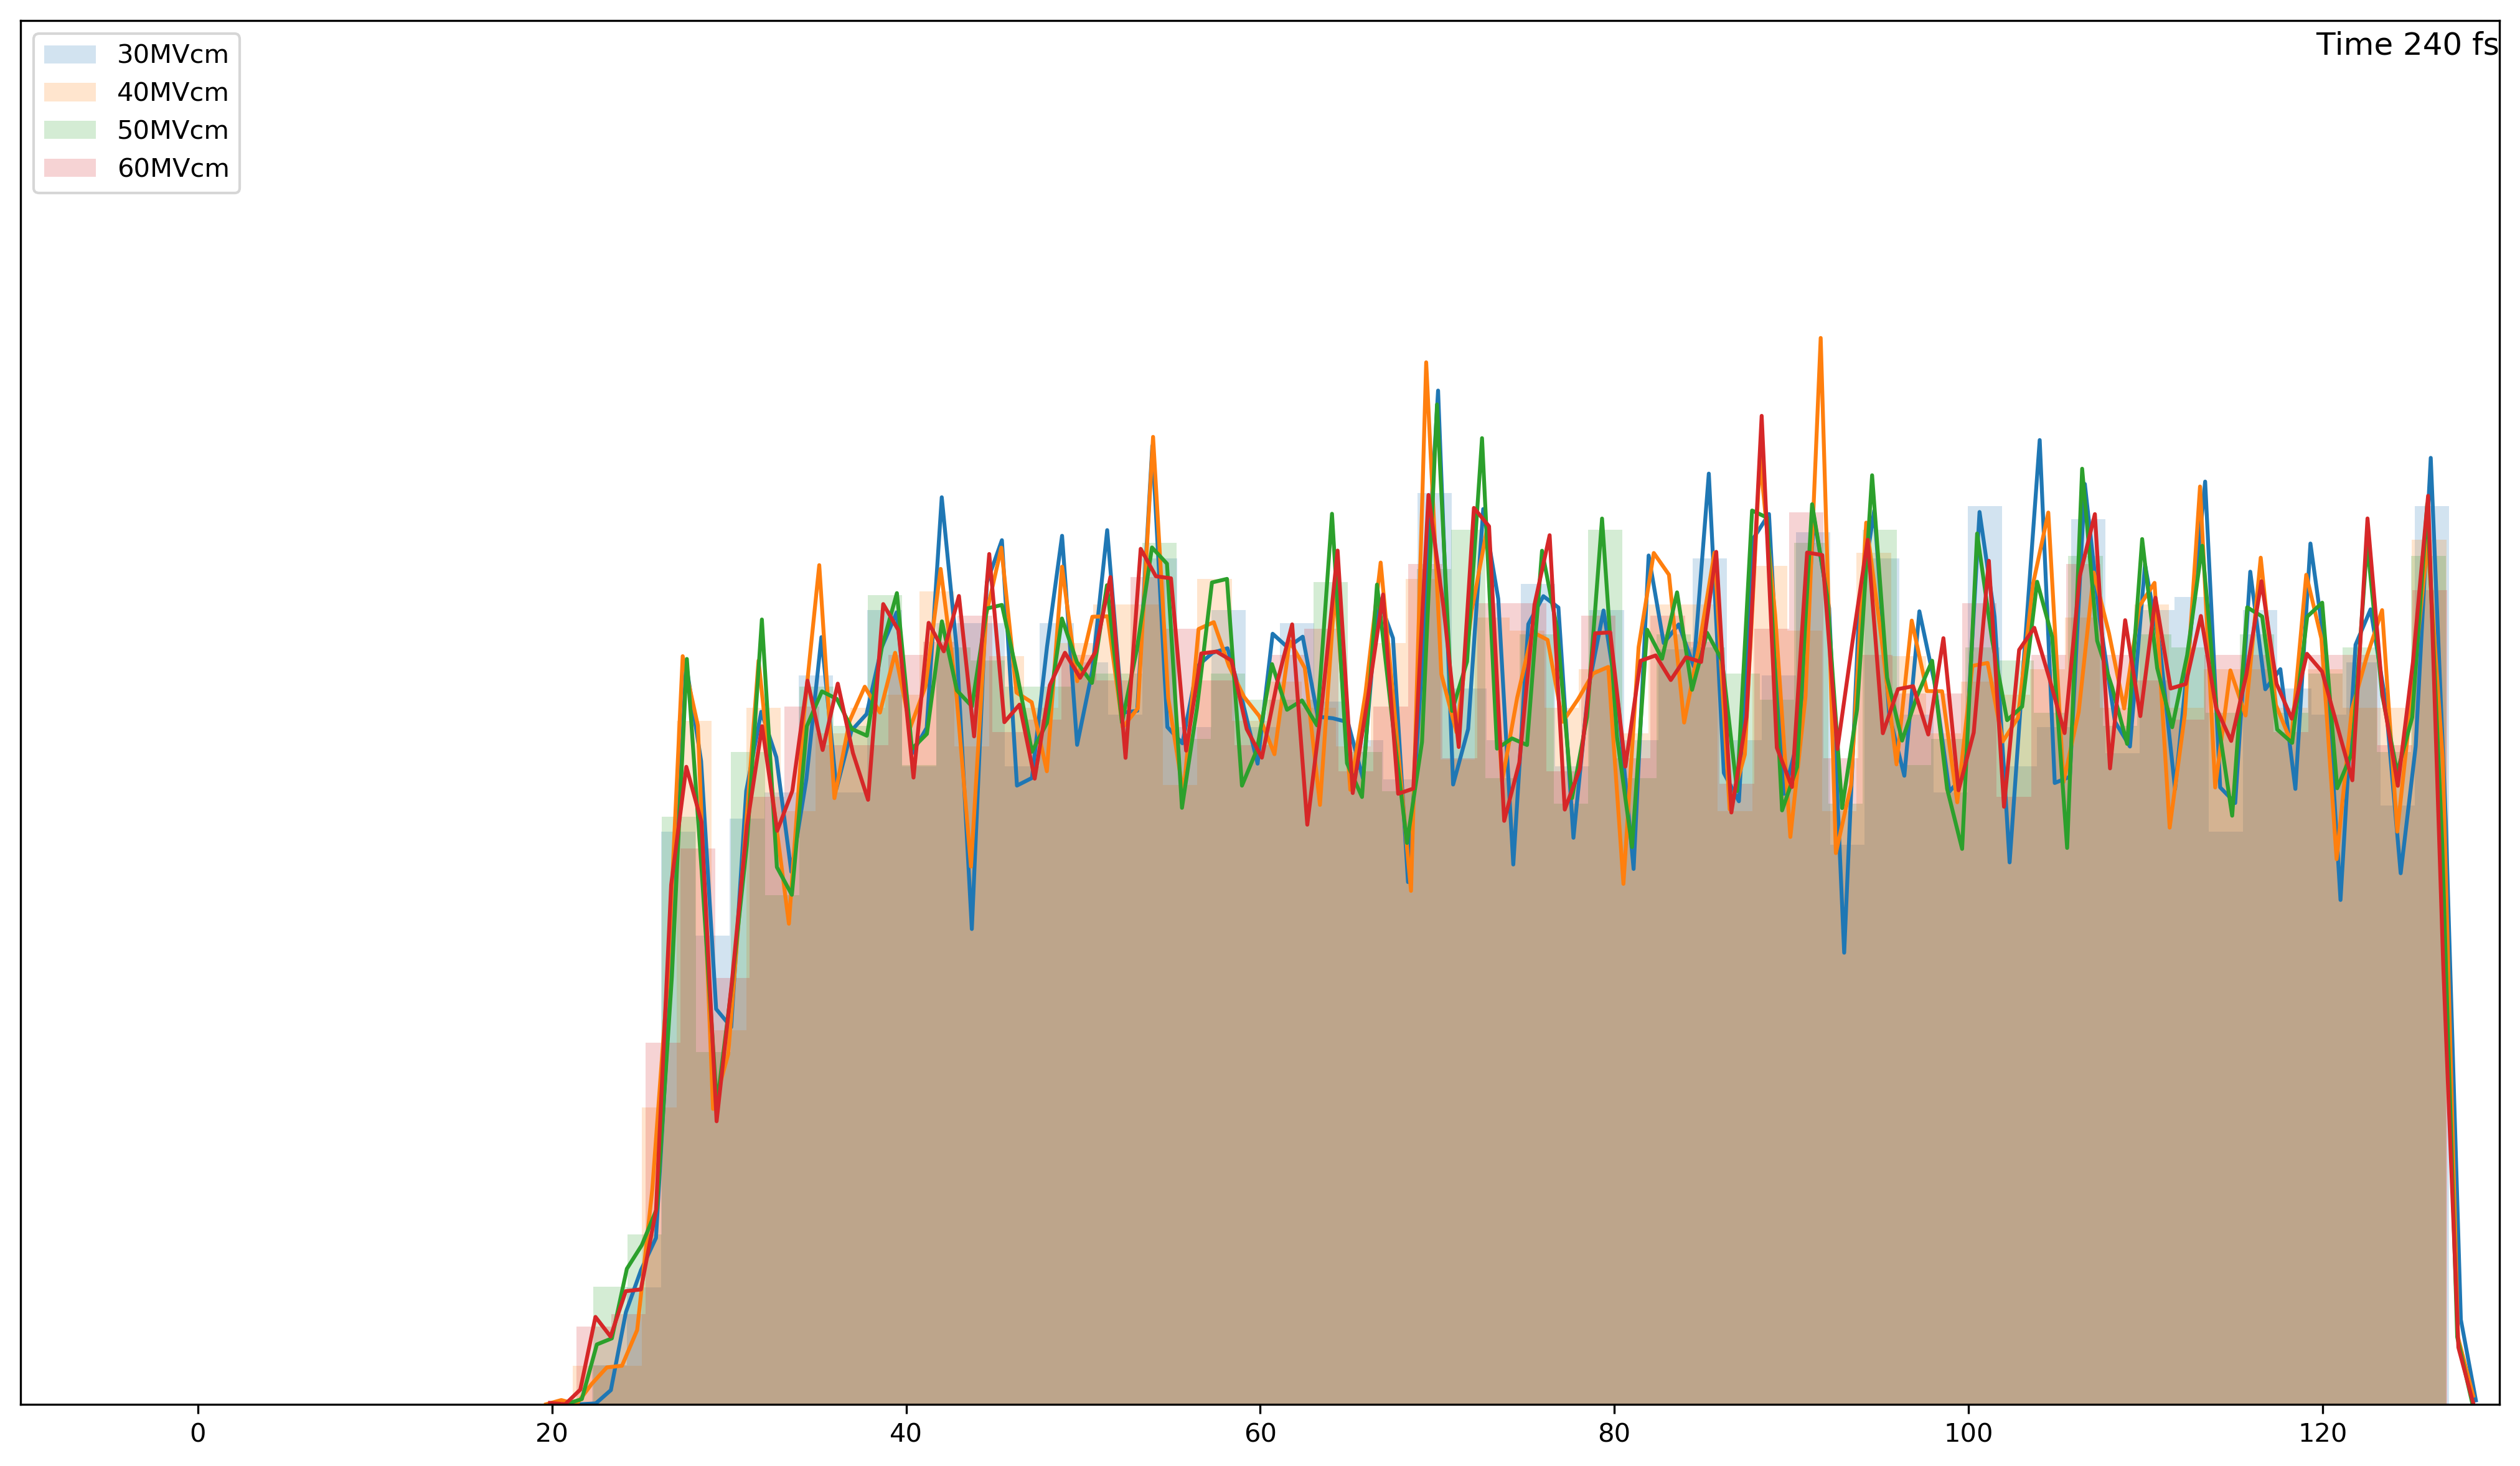

In [125]:
import subprocess

def testSubprocess(outf='testSubprocess.mp4', nframes=1):

    #set up the figure
    fig, ax = plt.subplots(figsize=(14, 8))
    fig.tight_layout()
    fig.set_dpi(300)
    canvas_width, canvas_height = fig.canvas.get_width_height()
    
    # First frame
    ax.tick_params(labelleft=False, left=False)
    sns.kdeplot([], ax = ax)
    ax.set_xlim(-10, 130)
    ax.set_ylim(0, 0.019)

    def update(num):
            ax.clear()
            sns.distplot(sim_list['O_pos_z'][0][num], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax = ax, label = sim_list['names'][0])
            sns.distplot(sim_list['O_pos_z'][1][num], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax = ax, label = sim_list['names'][1])
            sns.distplot(sim_list['O_pos_z'][2][num], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax = ax, label = sim_list['names'][2])
            sns.distplot(sim_list['O_pos_z'][3][num], bins='sqrt', hist_kws={'alpha': 0.2}, kde_kws={'bw':'0.5'}, ax = ax, label = sim_list['names'][3])
            ax.set_title('Time {} fs'.format(num*10), loc='right', pad=-13)
            ax.set_xlim(-10, 130)
            ax.set_ylim(0, 0.019)
            ax.legend(loc=2)

    # Open an ffmpeg process
    cmdstring = ('/local/yiming/miniconda3/bin/ffmpeg', 
                 '-y', '-r', '25', # overwrite
                 '-s', '%dx%d' % (canvas_width, canvas_height), # size of image string
                 '-pix_fmt', 'argb', # format
                 '-f', 'rawvideo',  '-i', '-', # tell ffmpeg to expect raw video from the pipe
                 '-crf', '20',
                 '-vcodec', 'libx264', outf) # output encoding
    p = subprocess.Popen(cmdstring, stdin=subprocess.PIPE)

    # Draw frames and write to the pipe
    for frame in range(nframes):
        # draw the frame
        update(frame)
        fig.canvas.draw()

        # extract the image as an ARGB string
        string = fig.canvas.tostring_argb()

        # write to pipe
        p.stdin.write(string)

    # Finish up
    p.communicate()

testSubprocess(outf='Fe_H2O_efield.mp4', nframes=len(sim_list['O_pos_z'][0]))

## backup nx graphing